In [4]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torcheval.metrics.functional import multiclass_f1_score

In [3]:
# !pip install torcheval

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
import json
df_train = json.load(open('train.json'))
df_test = json.load(open('test.json'))

In [7]:
# pad the sequences
def pad(data, max_len):
    X = []
    y = []
    for id in data:
        tokens = data[id]["text"].split(" ")
        n = len(tokens)
        if n <= max_len:
            tokens += ['<pad>'] * (max_len - n)
            data[id]["labels"] += ['O'] * (max_len - n)

            X.append(tokens)
            y.append(data[id]["labels"])

    return X, y

In [8]:
max_len = 84
X_train, y_train = pad(df_train, max_len)
X_test, y_test = pad(df_test, max_len)

In [9]:
X_val, y_val = X_train[-1000:], y_train[-1000:]
X_train, y_train = X_train[:-1000], y_train[:-1000]

In [10]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val)

(6995, 6995, 1411, 1411, 1000, 1000)

In [11]:
from gensim.models import Word2Vec
model = Word2Vec(X_train, vector_size=100, window=5, min_count=1, workers=4)

In [12]:
output_mappings = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}

In [14]:
from torch.utils.data import Dataset, DataLoader
class RNN_Dataset(Dataset):
    def __init__(self, X, y, model, output_mappings):
        self.X = X
        self.y = y
        self.model = model
        self.output_mappings = output_mappings

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # convert words to word embeddings
        X_idx = torch.tensor([ self.get_embedding(word) for word in self.X[idx]], dtype=torch.float32)
        # convert labels to label embeddings
        y_idx = torch.tensor([output_mappings[label] for label in self.y[idx]])
        return X_idx, y_idx

    def get_embedding(self,word):
        oov_vector = np.random.uniform(-0.1, 0.1, 100)
        # return self.model.wv[word]
        if word in self.model.wv:
            return self.model.wv[word]
        else:
            return oov_vector

In [15]:
# create dataloaders
train_dataset = RNN_Dataset(X_train, y_train, model, output_mappings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = RNN_Dataset(X_val, y_val, model, output_mappings)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = RNN_Dataset(X_test, y_test, model, output_mappings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [16]:
for idx, data in enumerate(train_loader):
    X, y = data
    print(X.shape, y.shape)
    break

torch.Size([32, 84, 100]) torch.Size([32, 84])


C:\Users\Ishit\AppData\Local\Temp\ipykernel_22196\1088338319.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_idx = torch.tensor([ self.get_embedding(word) for word in self.X[idx]], dtype=torch.float32)


In [17]:
def train(model,loss_fn,optimizer,train_loader, val_loader):
    epochs = 20
    train_losses = []
    val_losses = []
    train_f1 = []
    val_f1 = []
    accuracy_arr = []
    output_size = len(output_mappings)

    for epoch in range(epochs):

        # Training loop
        all_train_preds = []
        all_train_labels = []
        all_val_preds = []
        all_val_labels = []

        model.train()

        train_loss = 0
        for idx, data in enumerate(train_loader):
            X, y = data # 32 x 84 x 100, 32 x 84

            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X) # 32 x 84 x 27

            loss = loss_fn(y_pred.view(-1, output_size), y.view(-1))
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            all_train_labels.extend(y.view(-1).cpu().numpy())
            all_train_preds.extend(torch.argmax(y_pred.view(-1, output_size),dim=1).cpu().numpy())

        train_loss /= len(train_loader)
        # print(train_loss)
        train_losses.append(train_loss)

        f1 = multiclass_f1_score(torch.tensor(all_train_preds), torch.tensor(all_train_labels), num_classes = len(output_mappings) ,average='macro')
        train_f1.append(f1)

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0
            accuracy = 0
            for idx, data in enumerate(val_loader):
                X, y = data

                X = X.to(device)
                y = y.to(device)

                y_pred = model(X) # (32 x 84 x 27)

                # write loss function
                loss = loss_fn(y_pred.view(-1, output_size), y.view(-1))
                correct += (torch.argmax(y_pred.view(-1, output_size),dim=1) == y.view(-1)).sum().item()

                val_loss += loss.item()

                all_val_labels.extend(y.view(-1).cpu().numpy())
                all_val_preds.extend(torch.argmax(y_pred.view(-1, output_size),dim=1).cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            # write accuracy
            accuracy = correct/(len(y_val) * max_len)
            accuracy_arr.append(accuracy)
            f1 = multiclass_f1_score(torch.tensor(all_val_preds), torch.tensor(all_val_labels), num_classes = len(output_mappings) ,average='macro')
            val_f1.append(f1)

        if epoch % 1 == 0:
            print(f'Epoch {epoch+1} Train Loss {train_loss} Val Loss {val_loss} Val Accuracy {accuracy} Val F1 {f1}')

    return train_losses, val_losses, train_f1, val_f1, accuracy_arr


In [ ]:
# torch.tensor(all_train_preds).shape, torch.tensor(all_train_labels).shape

(torch.Size([587580]), torch.Size([587580]))

In [18]:
def test(model, test_loader):
    model.eval()
    output_size = len(output_mappings)
    with torch.no_grad():
        correct = 0
        all_test_preds = []
        all_test_labels = []
        for idx, data in enumerate(test_loader):
            X, y = data
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            correct += (torch.argmax(y_pred.view(-1, output_size),dim=1) == y.view(-1)).sum().item()

            all_test_labels.extend(y.view(-1).cpu().numpy())
            all_test_preds.extend(torch.argmax(y_pred.view(-1, output_size),dim=1).cpu().numpy())

        test_accuracy = correct/(len(y_test)*max_len)
        test_f1 = multiclass_f1_score(torch.tensor(all_test_preds), torch.tensor(all_test_labels), num_classes = len(output_mappings) ,average='macro')
        print(f'Test Accuracy {test_accuracy} Test F1 {test_f1}')


Models

In [45]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out
    
# GRU
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out
    
# bidirectional LSTM
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


In [ ]:
input_size = 100
hidden_size = 32
output_size = 27

In [40]:
rnn = RNN(input_size, hidden_size, output_size)
rnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.005)

In [41]:
# train the model
train_losses, val_losses, train_f1, val_f1, accuracy_arr = train(rnn, loss_fn, optimizer, train_loader, val_loader)

Epoch 1 Train Loss 0.35659074225382176 Val Loss 0.24064286844804883 Val Accuracy 0.9476904761904762 Val F1 0.05465857684612274
Epoch 2 Train Loss 0.2190516340678141 Val Loss 0.19722158508375287 Val Accuracy 0.9553452380952381 Val F1 0.09960455447435379
Epoch 3 Train Loss 0.18710152423817272 Val Loss 0.16939620347693563 Val Accuracy 0.9588214285714286 Val F1 0.15700703859329224
Epoch 4 Train Loss 0.17361707036217597 Val Loss 0.1651494069956243 Val Accuracy 0.9585 Val F1 0.16825008392333984
Epoch 5 Train Loss 0.16601187967138203 Val Loss 0.15756637998856604 Val Accuracy 0.9606190476190476 Val F1 0.225539430975914
Epoch 6 Train Loss 0.15977267516122018 Val Loss 0.1542608723975718 Val Accuracy 0.9610952380952381 Val F1 0.24914047122001648
Epoch 7 Train Loss 0.15568955576038795 Val Loss 0.14813117822632194 Val Accuracy 0.9615595238095238 Val F1 0.2385646104812622
Epoch 8 Train Loss 0.1516482488137402 Val Loss 0.14739298168569803 Val Accuracy 0.9615238095238096 Val F1 0.26881155371665955
Epo

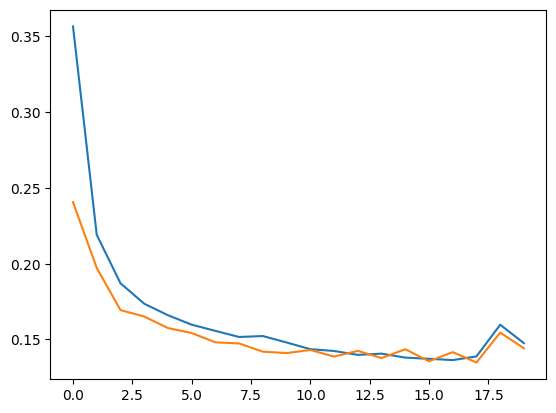

In [42]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

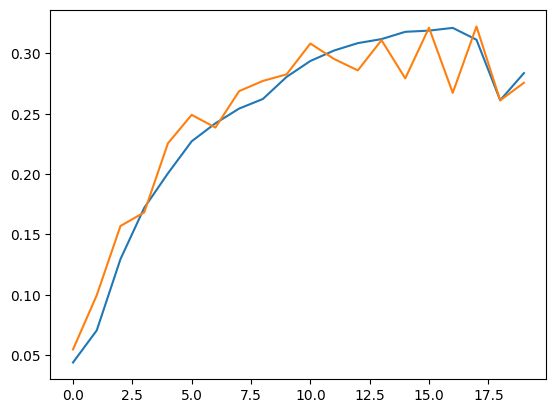

In [43]:
# plot the f1 scores
plt.plot(train_f1, label='train')
plt.plot(val_f1, label='val')

In [44]:
# test the model
test(rnn, test_loader)

Test Accuracy 0.9606071344200331 Test F1 0.27748802304267883


In [27]:
lstm = LSTM(input_size, hidden_size, output_size)
lstm.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.005)

In [28]:
# train the model
train_losses, val_losses, train_f1, val_f1, accuracy_arr = train(lstm, loss_fn, optimizer, train_loader, val_loader)

Epoch 1 Train Loss 0.3495135265126076 Val Loss 0.21813240787014365 Val Accuracy 0.9499642857142857 Val F1 0.056201525032520294
Epoch 2 Train Loss 0.19938496340355372 Val Loss 0.17444160231389105 Val Accuracy 0.9583452380952381 Val F1 0.16591545939445496
Epoch 3 Train Loss 0.16886681838803094 Val Loss 0.15550821903161705 Val Accuracy 0.9615833333333333 Val F1 0.21286189556121826
Epoch 4 Train Loss 0.1529870309513998 Val Loss 0.1473047297913581 Val Accuracy 0.9615595238095238 Val F1 0.22363793849945068
Epoch 5 Train Loss 0.14445555759551318 Val Loss 0.1373970105778426 Val Accuracy 0.96475 Val F1 0.2752136290073395
Epoch 6 Train Loss 0.13876684380856824 Val Loss 0.13414065749384463 Val Accuracy 0.9651904761904762 Val F1 0.29420822858810425
Epoch 7 Train Loss 0.1346866916439849 Val Loss 0.13353500119410455 Val Accuracy 0.9657142857142857 Val F1 0.31810474395751953
Epoch 8 Train Loss 0.13178222274331197 Val Loss 0.12947619357146323 Val Accuracy 0.9651309523809524 Val F1 0.3051186800003052
E

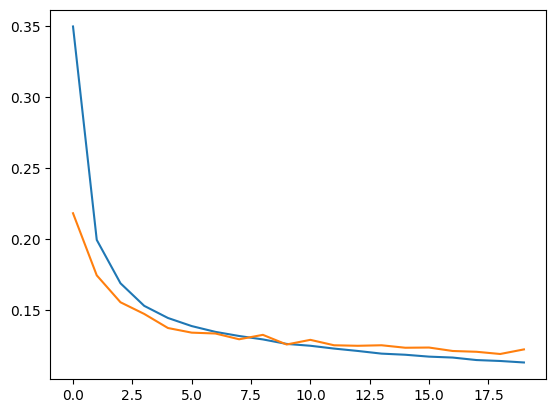

In [32]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

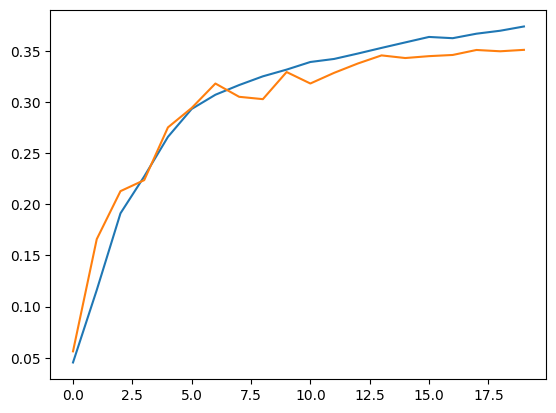

In [33]:
# plot the f1 scores
plt.plot(train_f1, label='train')
plt.plot(val_f1, label='val')

In [34]:
test(lstm, test_loader)

Test Accuracy 0.9660659444500692 Test F1 0.3530963659286499


In [35]:
gru = GRU(input_size, hidden_size, output_size)
gru.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru.parameters(), lr=0.005)

In [36]:
# train the model
train_losses, val_losses, train_f1, val_f1, accuracy_arr = train(gru, loss_fn, optimizer, train_loader, val_loader)

Epoch 1 Train Loss 0.36246871941438 Val Loss 0.2383647165261209 Val Accuracy 0.9486309523809524 Val F1 0.049687668681144714
Epoch 2 Train Loss 0.22304775388953893 Val Loss 0.19586839247494936 Val Accuracy 0.9546190476190476 Val F1 0.08133060485124588
Epoch 3 Train Loss 0.18527867542962506 Val Loss 0.17057266854681075 Val Accuracy 0.9574761904761905 Val F1 0.13473957777023315
Epoch 4 Train Loss 0.16705437494467382 Val Loss 0.1570157059468329 Val Accuracy 0.959 Val F1 0.1779925376176834
Epoch 5 Train Loss 0.15498613872348446 Val Loss 0.14697700971737504 Val Accuracy 0.96225 Val F1 0.22546561062335968
Epoch 6 Train Loss 0.14660366349024315 Val Loss 0.13832538155838847 Val Accuracy 0.9638571428571429 Val F1 0.26697683334350586
Epoch 7 Train Loss 0.13954744692126367 Val Loss 0.13524194480851293 Val Accuracy 0.9644047619047619 Val F1 0.29832303524017334
Epoch 8 Train Loss 0.13552787968012842 Val Loss 0.13287817523814738 Val Accuracy 0.96525 Val F1 0.31111034750938416
Epoch 9 Train Loss 0.131

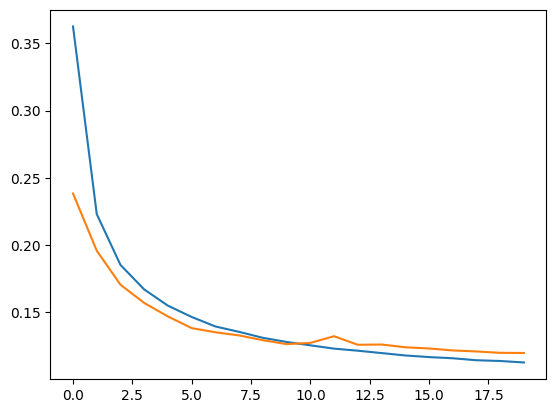

In [37]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

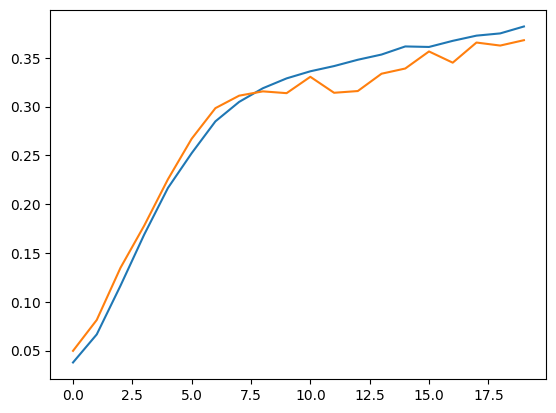

In [38]:
# plot the f1 scores
plt.plot(train_f1, label='train')
plt.plot(val_f1, label='val')

In [39]:
#test the model
test(gru, test_loader)

Test Accuracy 0.9660912557794202 Test F1 0.3617193102836609


In [46]:
# bidirectional LSTM
bi_lstm = BiLSTM(input_size, hidden_size, output_size)
bi_lstm.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bi_lstm.parameters(), lr=0.005)

In [47]:
# train the model
train_losses, val_losses, train_f1, val_f1, accuracy_arr = train(bi_lstm, loss_fn, optimizer, train_loader, val_loader)

Epoch 1 Train Loss 0.30994411697398583 Val Loss 0.18139448203146458 Val Accuracy 0.9564047619047619 Val F1 0.11195387691259384
Epoch 2 Train Loss 0.16515502081886274 Val Loss 0.145090565783903 Val Accuracy 0.963202380952381 Val F1 0.23743018507957458
Epoch 3 Train Loss 0.1420651614734027 Val Loss 0.13375846878625453 Val Accuracy 0.9647738095238095 Val F1 0.2585214078426361
Epoch 4 Train Loss 0.12923139466406547 Val Loss 0.12163205328397453 Val Accuracy 0.9675476190476191 Val F1 0.2997001111507416
Epoch 5 Train Loss 0.11993991304614228 Val Loss 0.11334859218914062 Val Accuracy 0.9695357142857143 Val F1 0.3478665053844452
Epoch 6 Train Loss 0.11382116030340325 Val Loss 0.11169956310186535 Val Accuracy 0.9708809523809524 Val F1 0.36928871273994446
Epoch 7 Train Loss 0.10967260277638696 Val Loss 0.10562607133761048 Val Accuracy 0.9717619047619047 Val F1 0.37619858980178833
Epoch 8 Train Loss 0.10629772124429272 Val Loss 0.10477811237797141 Val Accuracy 0.9719166666666667 Val F1 0.386530429

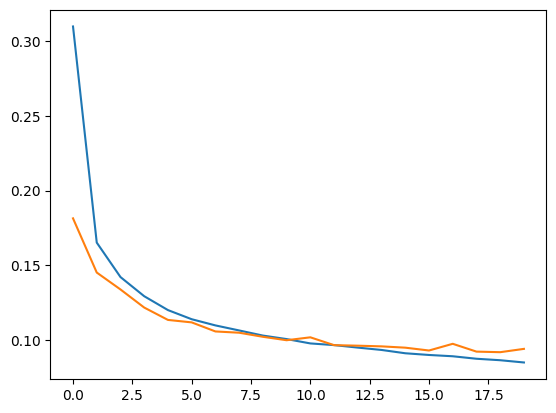

In [48]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

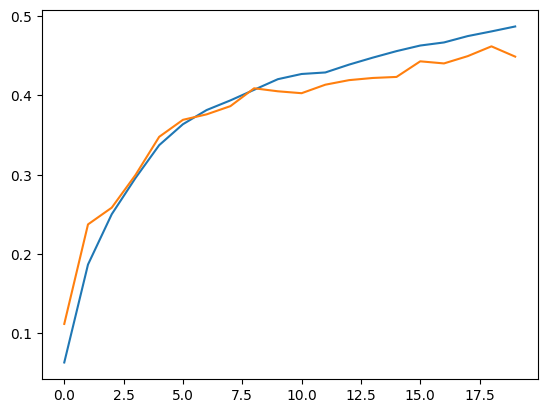

In [49]:
# plot the f1 scores
plt.plot(train_f1, label='train')
plt.plot(val_f1, label='val')


In [50]:
# test the model
test(bi_lstm, test_loader)

Test Accuracy 0.9733893557422969 Test F1 0.4476693868637085
